# Iceland Litli-Hrútur Eruption Figures and Analysis



In [1]:
%matplotlib inline

import os, sys, math, datetime, time
import scipy.stats as stats
import rasterio
import numpy
from rasterio.plot import show
from scipy import optimize
import datetime as dt
import matplotlib.transforms as transforms
from matplotlib import pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
})

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from dragonfly_util.mplogtocsv import parse_mplog
from dragonfly_util.logtocsv import parse_log
from dragonfly_util.ortho_map import OrthoMap
from dragonfly_util.plot_util import *
from dragonfly_util.reading import Reading
from sklearn.linear_model import LinearRegression

In [2]:
#la_palma_map_original = rasterio.open("la_palma_map4.tif")
#la_palma_map = rasterio.open("la_palma_map4c.tif")

In [3]:
def read_data(file):
    return parse_log(file, skip_zeroing=False)

def filter_data(input, predicate):
    filtered = []
    for i in input:
        if predicate(i):
            filtered.append(i.data)
    return filtered

def between(start, end):
    start_date = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    return lambda value: value.type =='reading' and start_date <= value.date and end_date >= value.date and value.data.value > 0

def get_next_point(input, time):
    threshold_date = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f')
    for value in input:
        if value.time > threshold_date:
            return value
    return None

figure_path = 'figures'
if not os.path.exists(figure_path):
   os.makedirs(figure_path)

def render_distance_data(starting_position, data, ambient, title, ax, min_distance=0, limit_distance=None, legend=True, use_max=False, plot_gaussian=True, max_co2=700, delegate=None):
    total = 0
    count = 0
    
    distance_data = []
    max_distance = 0
    
    for d in data:
        lat_diff = (starting_position.lat - d.lat) * (EARTH_CIRCUMFERENCE / 360) * math.cos(starting_position.lat * 0.01745)
        lon_diff = (starting_position.lon - d.lon) * (EARTH_CIRCUMFERENCE / 360)
        distance = lat_diff
        if distance > min_distance:
            distance_data.append({"distance": distance, "value": d.value})
            if(distance > max_distance):
                max_distance = distance
            
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            total = total + (relative_co2 * distance_data[i]["distance"])
            count = count + relative_co2
        
    mean = max_distance if use_max else total / count
    
    std_total = 0
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            distance_diff = distance_data[i]["distance"] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
    m = len(distance_data)
    
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))
    
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(((-(((x - mean) / stddev) ** 2)) / 2)) / (stddev * math.sqrt(2 * math.pi))

    def difference(s):
        difference_sum = 0
        for i in range(len(distance_data)) :
            if distance_data[i]["value"] > ambient:
                calculated_value = gaussian(distance_data[i]["distance"], s, mean, std_dev)
                calculated_difference = distance_data[i]["value"] - ambient
                difference = calculated_value - calculated_difference
                difference_sum = difference_sum + (difference ** 2)
        return difference_sum
    
    def gradient_descent(current, step_size, max_iter):
        current_x = current
        prev_difference = 1
        rate = 1
        precision = 0.00001
        previous_step_size = step_size
        
        for i in range(max_iter):
            previous_x = current_x
            
            value = difference(previous_x)
            value_plus = difference(previous_x + (previous_step_size * 0.1))
            
            df = (value_plus - value) / (step_size * 0.1)
            
            current_x = current_x - (rate * df)
            
        return [current_x, difference(current_x)]

    def flux(C):
        wind_speed = 10 # m/s
        seconds_in_day = 60 * 60 * 24 # s
        tonnes_per_mg = math.pow(10, -9) # tonnes
        CO2_molecular_weight = 44.01 # g / mol
        moles_per_liter = 24.45 # mol / l
        # g / mol * mol / l = g / l = g / 1000 m^3 = mg / m^3
        return math.pow((C * CO2_molecular_weight / moles_per_liter), 2) * wind_speed * tonnes_per_mg * seconds_in_day
    
    def area():
        
        area_sum = 0
        size = len(distance_data)
        for i in range(size):
            if distance_data[i]["value"] > ambient:
                left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
                right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
                area_sum += (distance_data[i]["value"] - ambient) * abs(right - left)
        
        return area_sum
    
    def render_scatter_areas(ax):
        
        size = len(distance_data)
        for i in range(size):
            if distance_data[i]["value"] > ambient:
                left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
                right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
                ax.add_patch(Rectangle((left, ambient), right - left, distance_data[i]["value"] - ambient, color='lightsteelblue'))
    
    [minimum_s, minimum_x2] = gradient_descent(0, 100, 1000)
    
    scatter_area = area()

    print("{}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(title, mean, std_dev, scatter_area, minimum_s, minimum_x2, flux(minimum_s)))
        
    x = np.linspace(mean - 5*std_dev, mean + 5*std_dev, 100)
    pdf = [(x) + ambient for x in gaussian(x, minimum_s, mean, std_dev)]
    
    if delegate is not None:
        delegate(ax)
    
    ax.title.set_text(title)
    render_scatter_areas(ax)
    ax.scatter([d["distance"] for d in distance_data], [d["value"] for d in distance_data], s=1, label="CO$_2$ readings")
    if plot_gaussian:
        ax.plot(x, pdf, c='r', label='Gaussian fit x2:{:.2f} flux:{:.2f}'.format(minimum_x2, flux(minimum_s)))
    ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance East from takeoff (m)')
    ax.set_ylabel('CO$_2$ Concentration(ppm)')
    if limit_distance is not None:
        ax.set_aspect('auto')
        ax.set_xlim(0, limit_distance)
        
    ax.set_ylim(400, max_co2)
    if legend:
        ax.legend()
    ax.plot()

def saveFigure(plt, name, dpi=72):
    plt.savefig(figure_path + "/" + name + ".pdf", format="pdf", dpi=dpi)
    plt.savefig(figure_path + "/" + name + ".png", format="png", dpi=dpi)

EARTH_CIRCUMFERENCE = 40008000

In [4]:
df1_data = read_data("data/run.log")

day1 = filter_data(df1_data, between('2023-7-15 0:00:00.0', '2023-7-15 23:59:00.0'))
day2 = filter_data(df1_data, between('2023-7-16 0:00:00.0', '2023-7-17 23:59:00.0'))

day1_flight1 = filter_data(df1_data, between('2023-7-15 14:00:00.0', '2023-7-15 14:15:00.0'))

day2_flight1 = filter_data(df1_data, between('2023-7-16 17:20:00.0', '2023-7-16 17:26:00.0'))
day2_flight1a = filter_data(df1_data, between('2023-7-16 17:20:00.0', '2023-7-16 17:22:30.0'))
day2_flight1b = filter_data(df1_data, between('2023-7-16 17:22:30.0', '2023-7-16 17:26:00.0'))
day2_flight2 = filter_data(df1_data, between('2023-7-16 20:17:00.0', '2023-7-16 20:30:00.0'))

day2_flight2a = filter_data(df1_data, between('2023-7-16 20:18:30.0', '2023-7-16 20:19:00.0'))

In [5]:
def display_data(name, readings, nlags=6):
    #display_data_path(readings, maps)
    
    display_data_altitude(readings)
    
    display_readings(readings)
    
    #display_scatter(readings, maps)
    
    #display_readings_krige(name, readings, maps, nlags=nlags)

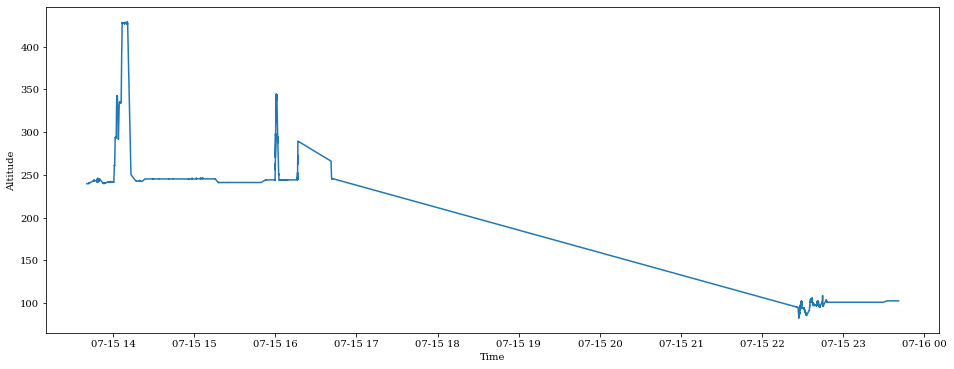

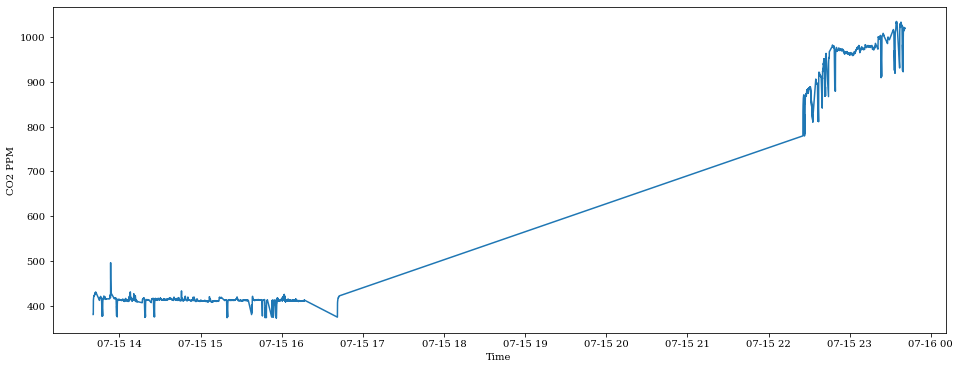

In [6]:
display_data('2023-7-15', day1)

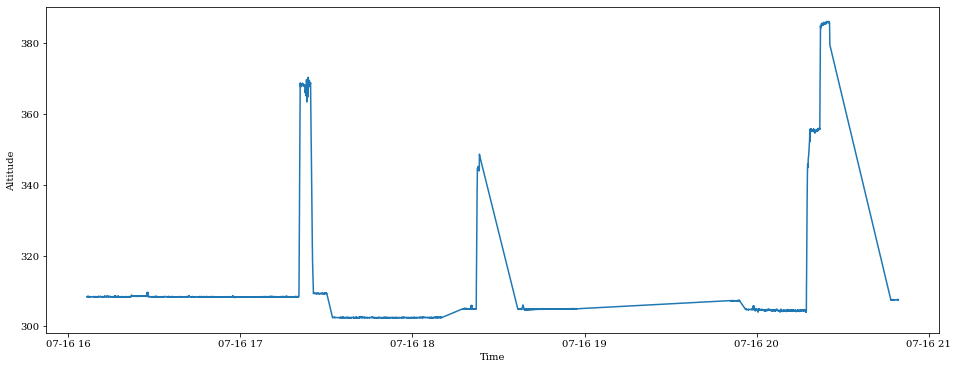

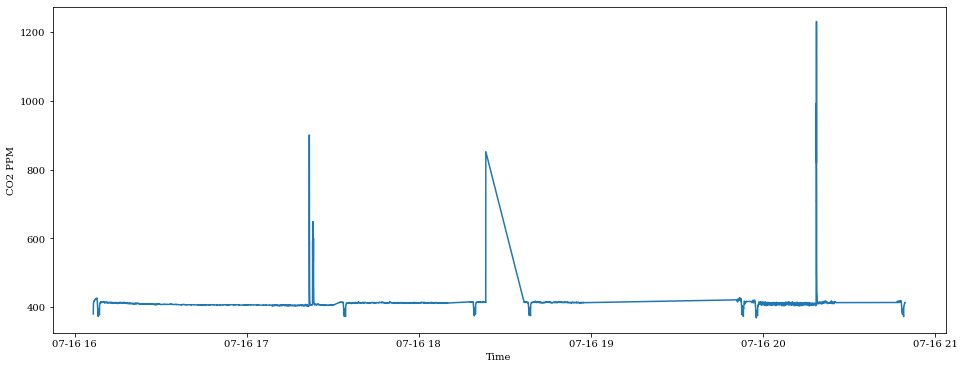

In [7]:
# fig, axs = plt.subplots(1, 1, figsize=(10, 15))

display_data('2023-7-16', day2)

# render_distance_data(day2[0], day2, 415, 'Day 1', axs, limit_distance=500, legend=True)

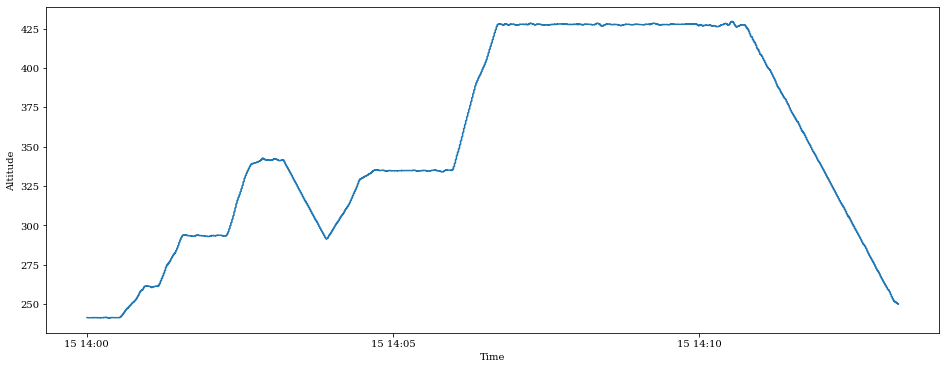

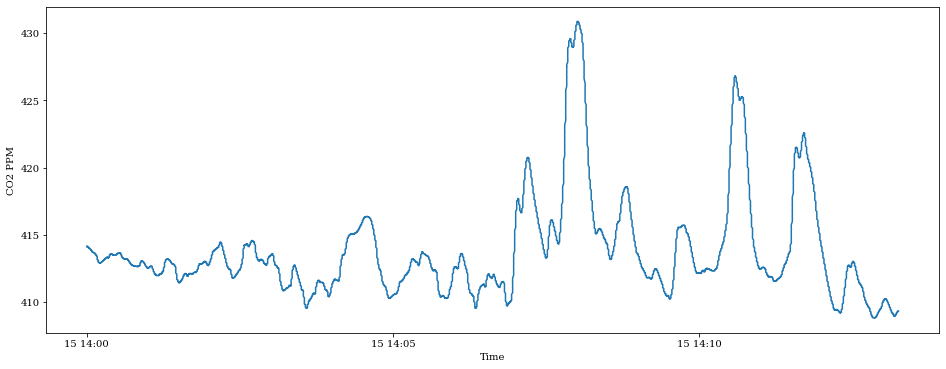

In [8]:
display_data('2023-7-15', day1_flight1)

Day 2 Transect out, 146.87, 8.80, 9869.45, 10449.70, 309530.97, 305679.63
Day 2 Transect back, 114.39, 23.25, 11570.01, 11254.93, 711911.43, 354604.56


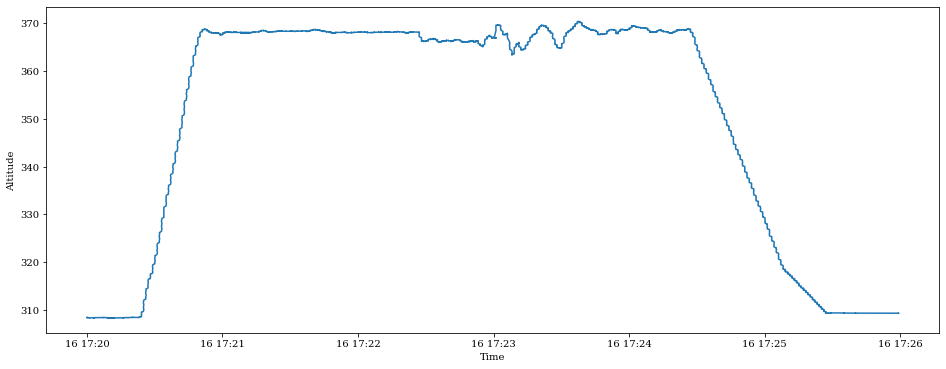

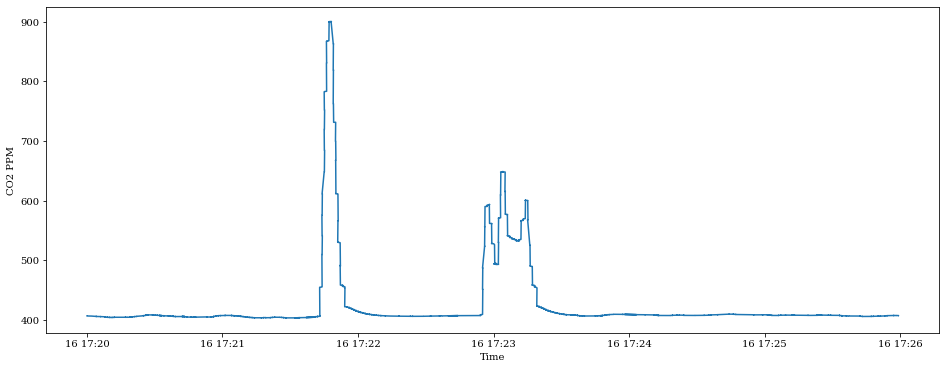

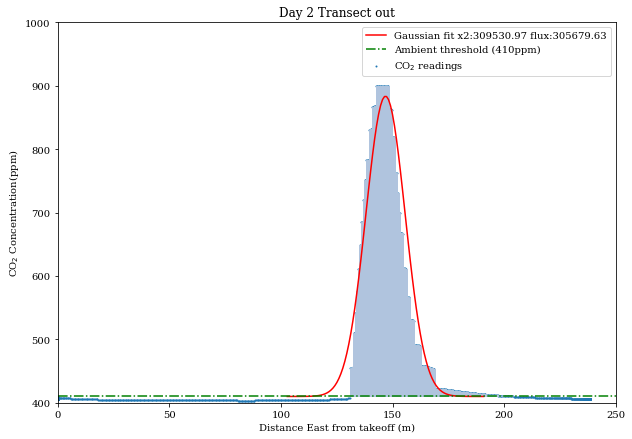

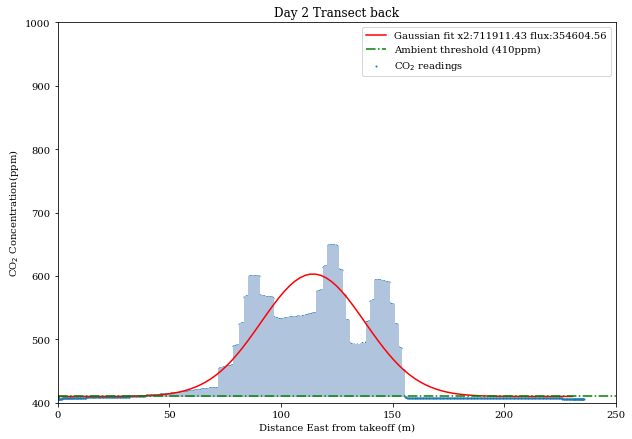

In [11]:
display_data('2023-7-15', day2_flight1)

ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1a[0], day2_flight1a, 410, 'Day 2 Transect out', axs, limit_distance=250, max_co2=1000, legend=True)
saveFigure(plt, 'transect1', dpi=300)

ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1a[0], day2_flight1b, 410, 'Day 2 Transect back', axs, limit_distance=250, max_co2=1000, legend=True)
saveFigure(plt, 'transect2', dpi=300)

Day 2 Curtain, 41.97, 6.00, 9016.79, 9273.36, 3765998.85, 240731.44


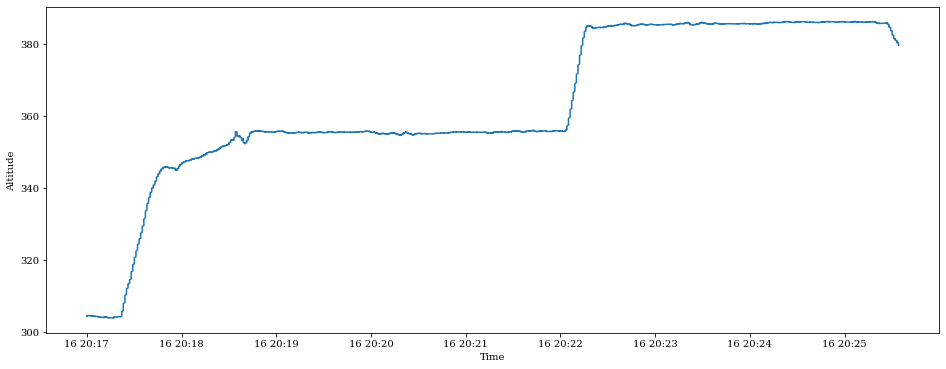

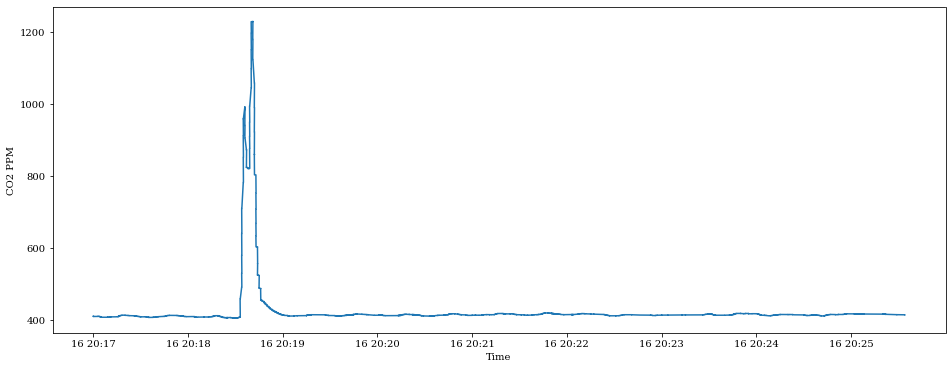

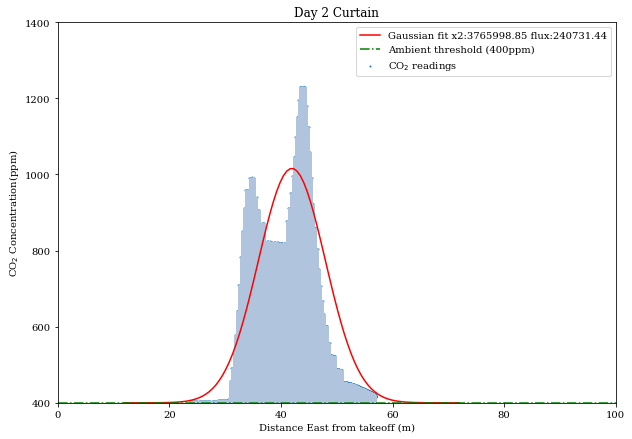

In [12]:
display_data('2023-7-15', day2_flight2)

ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1[0], day2_flight2a, 400, 'Day 2 Curtain', axs, limit_distance=100, max_co2=1400, legend=True)
saveFigure(plt, 'transect3', dpi=300)